In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
import nltk
import gensim
import operator
from sklearn.feature_extraction.text import CountVectorizer
import re
import textblob
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
import torch.nn.functional as F




from google.colab import drive
drive.mount('/content/drive')
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
train = pd.read_csv('/content/drive/MyDrive/df_train.csv', sep=",")
test = pd.read_csv('/content/drive/MyDrive/df_dev.csv', sep=",")


Mounted at /content/drive


In [2]:
def preprocess(phrases):
  processed_phrases = []
  for s in range(0, len(phrases)):
    processed = re.sub(r'<.*?>', ' ', str(phrases[s]))
    processed = re.sub(r'[^a-zA-Z0-9]',' ',processed)
    processed = re.sub(r'\s+', ' ', processed, flags=re.I)
    processed = re.sub(r'\w*\d\w*', '', processed)
    processed = processed.lower()
    processed_phrases.append(processed)
  return processed_phrases


In [3]:
!wget -nc https://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip
!ls -lat

--2022-12-20 03:29:33--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-12-20 03:29:33--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.02MB/s    in 2m 39s  

2022-12-20 03:32:12 (5.18 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflatin

In [4]:
glove_file = "glove.6B.300d.txt"
EMBEDDING_DIM = 300

cv1 = CountVectorizer()
cv1.fit(preprocess(train['Phrase']))

cv2 = CountVectorizer()
cv2.fit(preprocess(test['Phrase']))

all_words = set(cv1.vocabulary_.keys()).union(set(cv2.vocabulary_.keys()))

def get_embedding():
    embeddings_index = {}
    f = open(glove_file)
    for line in f:
        values = line.split()
        word = values[0]
        if len(values) == EMBEDDING_DIM + 1 and word in all_words:
            coefs = np.asarray(values[1:], dtype="float32")
            embeddings_index[word] = coefs
    f.close()
    return embeddings_index

embeddings_index = get_embedding()
print("Number of words that don't exist in GLOVE:", len(all_words - set(embeddings_index)))


Number of words that don't exist in GLOVE: 335


In [5]:

MAX_SEQUENCE_LENGTH = 80

tokenizer = Tokenizer()
tokenizer.fit_on_texts(np.append(train["Phrase"].values, test["Phrase"].values))
word_index = tokenizer.word_index

nb_words = len(word_index) + 1
embedding_matrix = np.random.rand(nb_words, EMBEDDING_DIM + 2)

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    sent = textblob.TextBlob(word).sentiment
    if embedding_vector is not None:
        embedding_matrix[i] = np.append(embedding_vector, [sent.polarity, sent.subjectivity])
    else:
        embedding_matrix[i, -2:] = [sent.polarity, sent.subjectivity]
        
seq = pad_sequences(tokenizer.texts_to_sequences(train["Phrase"]), maxlen=MAX_SEQUENCE_LENGTH)
labels = train.Sentiment.values
test_seq = pad_sequences(tokenizer.texts_to_sequences(test["Phrase"]), maxlen=MAX_SEQUENCE_LENGTH)
testlabels = test.Sentiment.values
seq = torch.tensor(seq)
labels = torch.tensor(labels)
test_seq = torch.tensor(test_seq)
testlabels = torch.tensor(testlabels)
embedding_matrix = torch.tensor(embedding_matrix)
dataset = TensorDataset(seq, labels)
testdataset = TensorDataset(test_seq, testlabels)
batch_size = 32
train_dataloader = DataLoader(dataset,sampler = RandomSampler(dataset),batch_size = batch_size)
validation_dataloader = DataLoader(testdataset,sampler = SequentialSampler(testdataset),batch_size = batch_size)
class_weights = []
n = len(labels)
for i in range(5):
  class_weights.append(1-sum(labels==i).numpy()/n)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)


In [6]:
class CustomModel(torch.nn.Module):
  def __init__(self, num_class = 5):
    super(CustomModel, self).__init__()
    self.filter_sizes=[5, 3, 1]
    self.num_filters=[100, 100, 100]
    self.embed = torch.nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
    self.lstm = torch.nn.LSTM(302, 128, batch_first=True,bidirectional=True)
    self.dropout = torch.nn.Dropout(0.25)
    self.conv1d_list = torch.nn.ModuleList([
    torch.nn.Conv1d(in_channels=256,
              out_channels=self.num_filters[i],
              kernel_size=self.filter_sizes[i])
    for i in range(len(self.filter_sizes))])

    self.dropout = torch.nn.Dropout(0.25)
    self.linear = torch.nn.Linear(np.sum(self.num_filters), num_class)


  def forward(self, x, label, weighted = True):
    x = self.embed(x).float()
    x, (h,c) = self.lstm(x) 
    x = x.permute(0, 2, 1)
    x_conv_list = [F.relu(conv1d(x)) for conv1d in self.conv1d_list]
    x_pool_list = [F.max_pool1d(x_conv, kernel_size=x_conv.shape[2])
                for x_conv in x_conv_list]
    x_fc = torch.cat([x_pool.squeeze(dim=2) for x_pool in x_pool_list],
                            dim=1)
    logits = self.linear(self.dropout(x_fc))
    if weighted:
      loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)
    else:
      loss_fct = torch.nn.CrossEntropyLoss()
    loss = loss_fct(logits.to(device).view(-1, 5), label.to(device).view(-1))
    return loss, logits

In [7]:
def train_model(model, epoch, add_on = "lstm", weighted = True):
  optimizer = torch.optim.AdamW(model.parameters(),lr = 2e-4, eps = 1e-8)
  scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5)
  model.train() 
  train_loss = 0
  iters = len(train_dataloader)
  i = 0
  for batch in train_dataloader:
      b_input_ids = batch[0].to(device)
      b_labels = batch[1].to(device)
      optimizer.zero_grad()
      outputs = model(b_input_ids, b_labels)
      loss=outputs[0]
      logit=outputs[1]
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
      optimizer.step()
      scheduler.step(epoch + i / iters)
      train_loss += loss.item()
      i += 1
  return train_loss

In [8]:
def valid_model(model, add_on="lstm", weighted=True):
  model.eval()
  pred=[]
  test_loss = 0
  for batch in validation_dataloader:
      b_input_ids = batch[0].to(device)
      b_labels = batch[1].to(device)
      with torch.no_grad():      
          outputs=model(b_input_ids, b_labels)
          loss=outputs[0]
          logit=outputs[1]
          test_loss += loss.item()
          pred.append(logit)
  return pred, test_loss

In [9]:
max_epoch = 5
train_loss_ = []
test_loss_ = []
model = CustomModel()
model.cuda()

pred_list = []
preds=[]
for epoch in range(max_epoch):
    train_ = train_model(model, epoch, add_on="lstm")
    train_loss_.append(train_)
    preds, test_ = valid_model(model)
    pred_list.append(preds)
    print("Epoch: {}, Training Loss: {}, Validation Loss: {}".format(epoch, train_, test_))


torch.save(model.state_dict(), "model.pth")

Epoch: 0, Training Loss: 3965.4867321252823, Validation Loss: 884.4577261805534
Epoch: 1, Training Loss: 3325.4901688992977, Validation Loss: 844.867170393467
Epoch: 2, Training Loss: 3047.665283501148, Validation Loss: 834.5661784410477
Epoch: 3, Training Loss: 2864.2645787000656, Validation Loss: 833.8039603829384
Epoch: 4, Training Loss: 2767.694039672613, Validation Loss: 835.8607844412327


Confusion Matrix



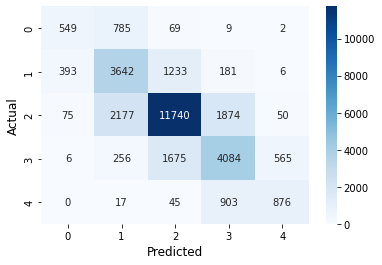


Classification Metrics

              precision    recall  f1-score   support

           0       0.54      0.39      0.45      1414
           1       0.53      0.67      0.59      5455
           2       0.80      0.74      0.77     15916
           3       0.58      0.62      0.60      6586
           4       0.58      0.48      0.52      1841

    accuracy                           0.67     31212
   macro avg       0.61      0.58      0.59     31212
weighted avg       0.68      0.67      0.67     31212



In [10]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
v=[]
idx=[]
for i in preds:
    for j in i:
        y=j.to('cpu').detach().numpy().copy()
        v.append(y)
        idx.append(np.argmax(y))

cf_matrix = confusion_matrix(test.Sentiment.values, idx)
print("Confusion Matrix\n")
sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual',fontsize=12)
plt.show()

lr_report = classification_report(test.Sentiment.values, idx)

print("\nClassification Metrics\n")
print(lr_report)

In [11]:
id_df = pd.DataFrame(test.Sentiment.values, columns=['true'])
pred_df = pd.DataFrame(idx, columns=['pred'])
Submission_df = pd.concat([id_df, pred_df], axis=1)
Submission_df.head()

,true,pred
0,3,3
1,0,1
2,1,1
3,2,2
4,3,3


In [12]:
Submission_df.to_csv('BiLSTM+CNN.csv', index=False)